In [1]:
"""
Created on Wed Dec 9 2020
Phase correction for distorted line shapes observed on infrared (IR) absorption spectra
Based on the work of: 
Gökçen Tek and Peter Hamm; A Correction Scheme for Fano Line Shapes in Two-Dimensional Infrared Spectroscopy.
https://doi.org/10.1021/acs.jpclett.0c01752
@author: zaphodcuk
"""
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.interpolate import CubicSpline
from scipy.optimize import leastsq

import tkinter as tk
from tkinter import filedialog

# necesssary functions

def find_spectral_idx(x): # finds the index of the closest pixel to the input
    new_x_raw = x_raw - x
    find_idx = np.where(np.absolute(new_x_raw) == np.amin(np.absolute(new_x_raw)))
    print(find_idx[0][0])
    return find_idx[0][0]

In [2]:
# load FTIR data

root = tk.Tk()
root.withdraw()

file_path = filedialog.askopenfilename(title = "Select file",filetypes = (("dpt files","*.dpt"),("text files","*.txt")))
print(file_path)
data = np.loadtxt(file_path)

C:/Users/gokce/Desktop/PhD/FTIR/paper_2/Au_thiol_35.dpt


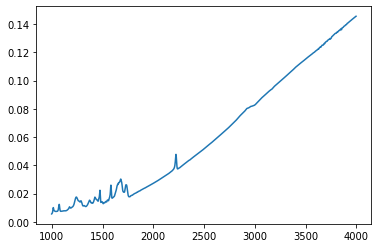

In [3]:
# plot raw data to decide on the range
x_raw = data[:,0]
y_raw = data[:,1]
plt.plot(x_raw,y_raw)

701
1206


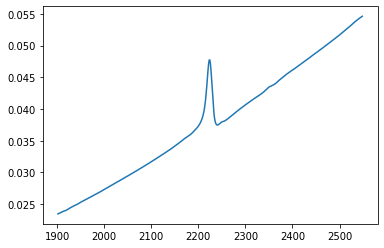

In [4]:
# select the range you want to apply phasing and plot

x_start = 1900
x_end = 2550 

x_start_idx = find_spectral_idx(x_start) + 1
x_end_idx = find_spectral_idx(x_end)

x_selected = data[x_start_idx:x_end_idx,0]
y_selected = data[x_start_idx:x_end_idx,1]

plt.plot(x_selected,y_selected)

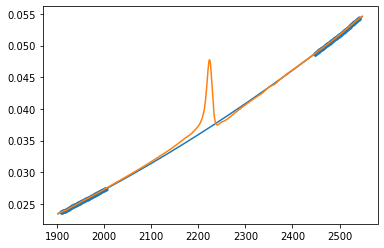

In [7]:
# offset subtraction : define a range, which will be used for obtaining a polynomial fit to then use for subtracting 

cut_range = 80 
x_cut = np.concatenate((x_selected[5:cut_range], x_selected[-cut_range:-5]))
x_cut = np.concatenate((x_selected[5:cut_range], x_selected[-cut_range:-5]))
y_cut = np.concatenate((y_selected[5:cut_range], y_selected[-cut_range:-5]))
y_cut = np.concatenate((y_selected[5:cut_range], y_selected[-cut_range:-5]))

pfit = np.polyfit(x_cut,y_cut,2)
yfit = np.polyval(pfit, x_selected)

plt.plot(x_selected, yfit)
plt.plot(x_selected, y_selected)
plt.scatter(x_cut, y_cut, s=10)

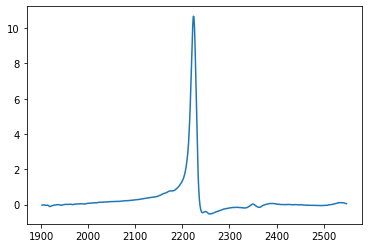

In [9]:
# obtain and plot offset subtracted data

x_data_real = x_selected
y_data = y_selected - yfit # subtract offset

plt.plot(x_data_real, y_data * 1000)

best phase:  0.4
354


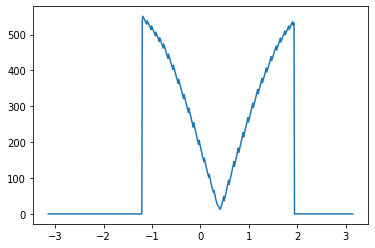

In [13]:
# inverse FT and check for the most symmetric lineshape: 

inter_no = len(y_data) + 1001 
width = 120 # width to consider when checking for symmetry
phase_start = -314 
phase_end = 315 

sum_total = np.empty(phase_end-phase_start)
phase_list = np.empty(phase_end-phase_start)
phase_factor_list = np.empty(phase_end-phase_start)
ft_data = np.empty((phase_end-phase_start, len(y_data)))
y_spline = np.empty((phase_end-phase_start, inter_no))


for i in range(phase_start, phase_end): # from -Pi to +Pi
    index = i + -phase_start    
    phase_factor = i/100
    phase_list[index] = phase_factor # list of all angles from -Pi to +Pi
    ift = np.fft.ifft(y_data) # inverse ft 
    ift_half = ift[0:int(len(x_data_real)/2)] # take the left half    
    ift_pad = np.concatenate((ift_half, np.zeros(int(len(x_data_real)/2)))) # zero pad 
    ift_pad[0] = ift_pad[0]/2 # special treatment of the first point before FT

    ft = np.fft.fft(ift_pad) # FT back to the frequency domain
    ft_data[index,:] = 2*np.real(ft*np.exp(1j*phase_factor)) # multiply with 2 since only the half of the raw data is taken
    
       
    ### checking for symmetry to obtain the phase correction factor
    
    ### INTERPOLATE ### interpolation is only done for checking symmetry, basically having more points to consider

    cs = CubicSpline(x_data_real, ft_data[index,:] * 1000)
    xs = np.linspace(x_data_real[0], x_data_real[-1], inter_no) # 5040
    
    x_spline = xs
    y_spline[index,:] = cs(xs)   
    
    w0 = np.argmax(np.absolute(y_spline[index,:])) # to find the w0 for each FT iteration         
    
    temp_sym = []  
    
    for j in range(1, width): # (1, width)
        if y_spline[index,w0] == abs(y_spline[index,w0]): # this is to have a lineshape which has a positive value at w0 
          
            diff = abs(y_spline[index,w0-j]-y_spline[index,w0+j]) # symmetrize           
        else:
            diff = 0 # to eliminate inverted line shapes (negative maxima)          
        
        temp_sym.append(diff)       
        np.array(temp_sym)        
        temp_sum = np.sum(temp_sym)
    
    sum_total[index] = temp_sum
    
     
    
mask = (sum_total > 0)
subset_idx = np.argmin(sum_total[mask])
parent_idx = np.arange(sum_total.shape[0])[mask][subset_idx]   

best_phase_idx = parent_idx
best_phase = phase_list[best_phase_idx]

plt.plot(phase_list, sum_total)

print('best phase: ', best_phase) # phase of the most symmetric line shape
print(best_phase_idx) # index of the best_phase

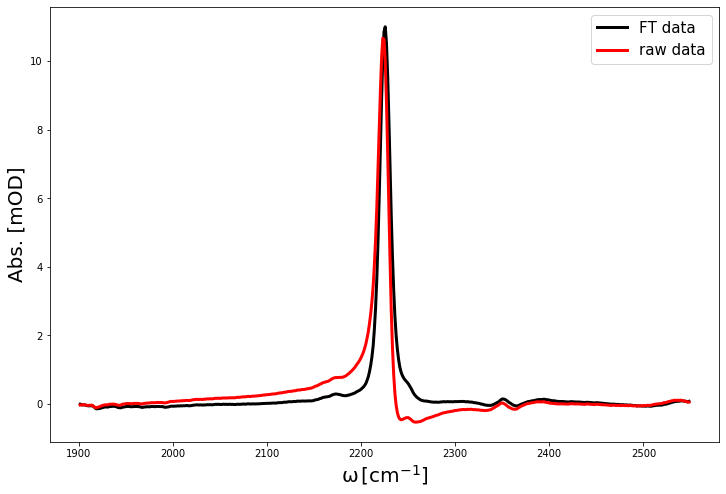

In [12]:
### plot phased and raw data

# repeat the same inverse FT, but now for only a single phase number, that is obtained from above

ift = np.fft.ifft(y_data) # inverse ft 
ift_half = ift[0:int(len(x_data_real)/2)] # take the left half
ift_pad = np.concatenate((ift_half, np.zeros(int(len(x_data_real)/2)))) # zero pad 16 pix to the end 
ift_pad[0] = ift_pad[0]/2 # special treatment of the first point before FT

ft = np.fft.fft(ift_pad)  
ft_data = 2*np.real(ft*np.exp(1j*best_phase))



plt.figure(figsize=(12,8))
plt.xlabel(r"$\mathrm{\omega\,[cm^{-1}]}$",fontsize=20) 
plt.ylabel('Abs. [mOD]',fontsize=20) # r"$\mathrm{T_2\,[ps]}$" # 'Arb. Units'  'Abs.'

plt.plot(x_data_real, ft_data*1000 , color='black' , linewidth=3, label = 'FT data')
plt.plot(x_data_real, y_data*1000 , color='red' , linewidth=3, label = 'raw data')
plt.legend(loc='best', fontsize=15)